## A Practical Beginners Guide to Image Pre-processing for Classification Using OpenCV
* Last updated: 7/2018
* The images used were pulled from The International Skin Imaging Collaboration (ISIC) Database https://isic-archive.com
* note: not a guide on short titles or non-run-on sentences
### Motivation:
* Whether it's the removal of outliers or the filling of empty data cells, "cleaning" data sets is often a requisite first step. Data noise only serves to hurt your results because after all, 💩 data in = 💩 results out. 
* In the case of image classification, consider your images to beyour data. For this reason, we'll seek reduce image noise by tightening the crop on the region of interest (ROI) for pictures of skin lesions.

In [1]:
import cv2                               # pip install opencv-python
from math import sqrt                    # included in standard library
from matplotlib import pyplot as plt     # pip install matplotlib
import numpy as np                       # pip install numpy
import os                                # std. lib
from random import sample                # std. lib

In [2]:
# Let's set some constants
# You've probably heard of RGB which describes the red, blue, and green color intensities of each pixel in an image.
# 255 is the maximum pixel intensity for any given color, thus we have:
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, )

# Here I set how many images we intend to view at once, their size, and the center coordinate (useful for later!)
SAMPLE_SIZE = 5
IMG_SIZE = 156
CENTER_DIST = int(IMG_SIZE / 2)
CENTER = (CENTER_DIST, CENTER_DIST)

# A place for our future images to call home (you'll see) 
concat_imgs = []

In [3]:
# I change directories because my test images are stored in a subfolder
os.chdir('CV_tests')

# os.listdir() returns a list of the file's contents as strings
# At this stage, imgs is a list image names based on the forementioned sample size
imgs = sample(os.listdir(), SAMPLE_SIZE)
# For continuity, I'll hardcode the list
imgs = [ '0000014_benign.png', '0000245_benign.png', '0000038_benign.png', '0000187_benign.png', '0000468_benign.png']

In [4]:
# * operator unpacks the list (or any sequence) into positional arguments
print(*imgs)

0000014_benign.png 0000245_benign.png 0000038_benign.png 0000187_benign.png 0000468_benign.png


In [5]:
# A normal list would print like so:
print(imgs)

['0000014_benign.png', '0000245_benign.png', '0000038_benign.png', '0000187_benign.png', '0000468_benign.png']


### Some helper functions before things get rolling

In [6]:
# Helper function that finds the euclidean distance between 2 coordinate pair tuples
def dist_tuples(tupA, tupB):
    return( sqrt ( ( tupB[1] - tupA[1] ) ** 2 + ( tupB[0] - tupA[0] ) ** 2) )

In [7]:
# Helper function to change our images to/from gray <-> color
# If it's gray, make it BGR, else make it gray
def convert(img):
    if len(img.shape) == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [8]:
# Returns the distance from contour's (more on what a countor is later) center of mass to the center of image
# For more details check out https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def contour_dist_to_center(c):
    M = cv2.moments(c)
    cX = int(M["m10"] / max(M["m00"], 1))
    cY = int(M["m01"] / max(M["m00"], 1))
    pt = (cX, cY)
    return dist_tuples(pt, CENTER)

## It is always a good idea to take a thorough look at your data
* Pete Warden, former CTO of Jetpac, recommends spending at least a few hours looking at your data (as do most data scientists). <a href="https://petewarden.com/2018/05/28/why-you-need-to-improve-your-training-data-and-how-to-do-it/">Check out Pete's full article on improving your training data here</a>. 
* For our purpose (and because I know that ISIC streamlines their picture-taking process) we'll just look at a few.

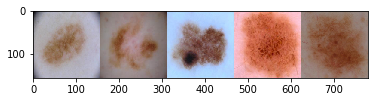

In [9]:
# Let's make a list of equally-sized images using:
# cv2.resize(image, (width, height))
# where image is the string name of a picture in your current directory and width/height are ints
all_imgs = [cv2.resize( cv2.imread(img), (IMG_SIZE, IMG_SIZE) ) for img in imgs]

# Then we'll horizontally concatenate these images using:
# cv2.hconcat([list of images])
concatenated_imgs = cv2.hconcat([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in all_imgs])
# Note that the above operations can be combined into a 1-liner, but I'll often separate these for ease of vision

# Use pyplot to show our buddied-up pics
plt.imshow(concatenated_imgs)

## Pretty aren't they? Before we begin...
* Going forward, it's important to note that any omitted details of the following image transformations can be found in the <a href="https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html">OpenCV documentation here</a>.

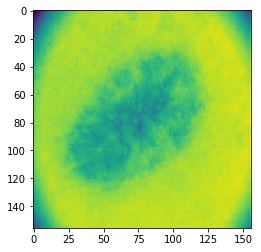

In [10]:
# Consider the first image
img1 = imgs[0]
img1 = cv2.imread(img1)
img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

# .copy() allows the original to remain unchanged
gray1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2GRAY)
plt.imshow(gray1)

### That's not grayscale 🤔
* Notice how I'm using Matplot to show the images instead of OpenCV? That's purely because Jupyter Notebooks (what I'm writing in) integrate better with Matplot when displaying images. Case in point, this oddly colored image.
* In short, Matplot reads the OpenCV image (3D numpy array) as a colored image, so we must be explicit in stating that it's grayscale
* Note: the condensed OpenCV-only code will be provided at the end.

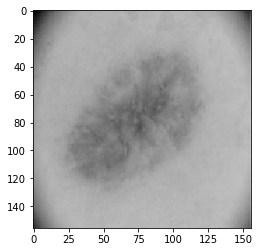

In [11]:
plt.imshow(gray1, cmap = "gray", vmin = 0, vmax = 255)

### In your own non-Jupyter workflow, consider the following code to display your images using OpenCV:
* <code>cv2.imshow("Your title", your_cv2_img)</code>

### Down the pipeline we go

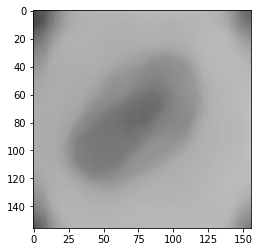

In [12]:
# Throwing a blur on gray will help us further reduce noise 
# I find that median blur works better than Gaussian blur for this purpose
# cv2.medianBlur(your_cv2_img, blur_size)
blurred1 = cv2.medianBlur(gray1.copy(), 21)

plt.imshow(blurred1, cmap = "gray", vmin = 0, vmax = 255)

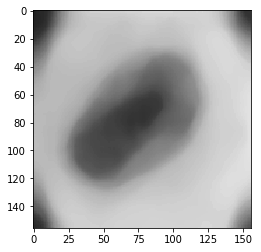

In [13]:
# CLAHE: Contrast Limited Adaptive Histogram Equalization (because who wouldn't have guessed that, right?)
# AHE is a contrast amplifier which works increase local contrast within some grid of pixels
# CLAHE attempts to limit noise within homogeneous areas of the image which is introduced with AHE 
# More details here: https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (1, 1))
cl1 = clahe.apply(blurred1)

plt.imshow(cl1, cmap = "gray", vmin = 0, vmax = 255)

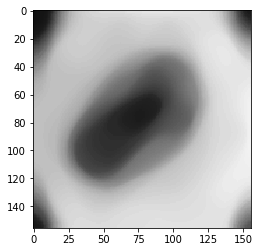

In [14]:
# For good measure, we'll do one more round of blurring/contrast enhancing
blurred2 = cv2.medianBlur(cl1.copy(), 15)
cl2 = clahe.apply(blurred2)

# Note how obvious the areas of interest become
plt.imshow(cl2, cmap = "gray", vmin = 0, vmax = 255)

### Let's talk about contours
* With the above image, it's safe to assume that most could identify any areas of interest. Just as we'd scour our skin for spots that stand out, we need to threshold our image to do the same.
* Un-technically speaking, contours are lists of points that outline some blob. By thresholding our image, we can binarize it, revealing contours.
* There are different kinds of thresholds -- a standard threshold, for example, accepts only pixels above or below a certain intensity and disregards the rest. This could work, but skin is naturally differing, uneven or even splotchy. Because of this, a standard threshold may throw many false-positive/negatives. This fact warrants a more flexible option: <a href="https://docs.opencv.org/3.4.1/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3">the adaptive threshold</a>. The adaptive threshold considers the intensity of neighboring pixels when calculating the threshold value for each pixel.

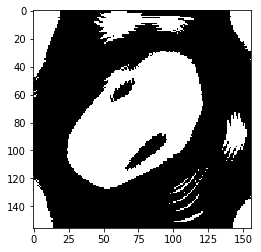

In [15]:
# Let's take this piece by piece (documentation is your friend!)
# cv2.adaptiveThreshold(your_cv2_img, new_max_pixel_intensity, 
#                       cv2.some_adaptive_threshold_algorithm,
#                       cv2.threshold type, neighborhood_size, 1)
# New max pixel intensity determines that the new image will be black and white when set to 255
# Get more info on threshold types with the above link
# Threshold type determines whether areas of interest will be white on black or vice versa
# The bigger the neighborhood size, the more it acts like a standard threshold
# The C value tweaks the way the algorithm calculates the pixel intensity. Leave it at 1 or 0 in most cases.
mask1 = cv2.adaptiveThreshold(cl2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 65, C = 1)

plt.imshow(mask1, cmap = "gray", vmin = 0, vmax = 255)

### Reducing false blobsitives
* At this point, it's not hard to see that a bounding box could encapsulate the blobs
* However there are a few precautions that we should take before calling it a day
* Artifacts or otherwise unwanted blobs -- hairs for example -- may sneak their way into our contours and pose as a "blob of interest"  
  
### Erosion and Dilation
* As the name suggests, eroding the contours will eat away at the weakest parts. This will help us remove artifacts like hair and leave only the most prominent blobs. 
* After erosion, dilation will help us return the forementioned "most prominent blobs" to their original girth -- for dire lack of a better word.

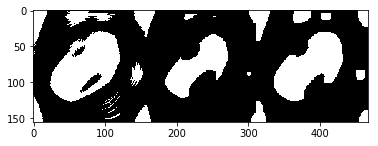

In [16]:
# Here we create a numpy array to act as our kernel for erosion and dilation.
# This kernel effectively determines the intensity of the erosion and dilation
# Note that the tuple (5, 5) can be modified to affect the x/y axis differently, ex: (1, 5)
kernel = np.ones((5, 5), np.uint8 )

# Note, I'm still experimenting with the iteration count. Find out what works best for your use case
eroded = cv2.erode(mask1, kernel, iterations = 2)
dilated = cv2.dilate(eroded, kernel, iterations = 2)
# A side-by-side view
mask1_eroded_dilated = cv2.hconcat([mask1, eroded, dilated])

# Note how the contours overall look more round and less busy
plt.imshow(mask1_eroded_dilated, cmap = "gray", vmin = 0, vmax = 255)

### Gotta find 'em all (<a href="https://docs.opencv.org/3.0.0/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a">contour documentation</a>)
* So what logic should dictate what is an important blob vs an unimportant blob?
* For your use case, consider any of the following: position, shape, size, color.
* We've lucked out in that most of the lesions are centered (position).
* For images like '0000245_benign.png' however, the lesion is splotchy and somewhat scattered
<img src="CV_TESTS/0000245_benign.png">
* The simple fix? Trusting that our erosion and dilation efforts remove most artifacts, let's accept contours that are close to the center of the image by some factor of the distance of the closest contour. This works with the fact that most lesions tend to cluster.
* In other words, if the closest contour is 50 pixels away from the center, let's accept all contours which are 50 * some_factor pixels from the center.
* Outside of training an image classifier to accomplish this task for us, there is no optimal way of doing this. This works because it was tested against the images and proven to work. Observation and experimentation are key!

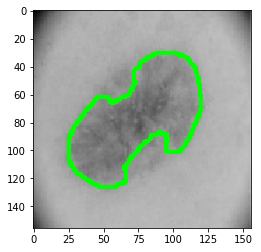

In [17]:
# Now to find the contours
# Note: setting a return value to _ is the pythonic way of saying "I don't want this"
# cv2.RETR_EXTERNAL specifies that we don't want mini-contours within our contours
# cv2.CHAIN_APPROX_SIMPLE returns the minimal amount of points for the given contour (memory efficiency!)
_, contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Let's resort our list of contours by their distance to the center of the image (SEE ABOVE HELPER FUNCTIONS!)
# sorted(list, key = function_with_some_sortable_return_value)
contours = sorted(contours, key = contour_dist_to_center)

# Isolate the most central contour
central_contour = contours[0]
final_contours = central_contour # for now, at least

# Now to find all viable contours
# But only if there's more than 1!
if len(contours) > 1:
    contour_threshold = contour_dist_to_center(central_contour) * 2 # there's that distance factor we talked about
    # In order to "add" the contours, we must convert them to ordinary lists (I have yet to find a better method on StackOverflow...)
    final_contours = final_contours.tolist()
    for contour in contours:
        if contour_dist_to_center(contour) < contour_threshold:
            final_contours += contour.tolist()
    # Revert the contours back to a numpy array
    final_contours = np.array(final_contours)

# The contours must now be drawn onto some canvas
# Can't draw color on a grayscale image, so first convert
gray_color = convert(gray1)
# cv2.drawContours(your_canvas, [list of contours], -1 to show all contours, contour_color, line_width or -1 to fill)
drawn_contour = cv2.drawContours(gray_color, [final_contours], -1, GREEN, 2)

# The outlines are a bit wonky because of how the drawContours interprets our "added" contours
# This could be resolved by drawing the contours on invidually
# However, because we want to crop ALL contours, this is necessary
plt.imshow(drawn_contour)

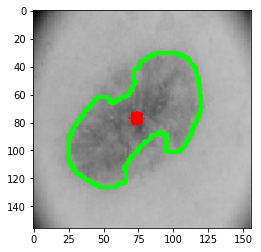

In [18]:
# Now to find the center of gravity (CG) of the contour
# In other words, if you were to cut the contour out of paper, where would it balance perfectly about your finger?
# The documentation does well in explaining this, but you really don't need to know much
# The CG will go unused (other than for aesthetics) for this example, but may serve a purpose in some other context
M = cv2.moments(final_contours)
# center X, Y coordinates
cX = int(M["m10"] / max(M["m00"], 1))
cY = int(M["m01"] / max(M["m00"], 1))

# Let's draw a circle at the CG
# cv2.circle(your_canvas, (x coord, y coord), desired_color, point width or -1 to fill)
cv2.circle(gray_color, (cX, cY), 5, RED, -1)

# A quick glance tells me that this CG looks about right
plt.imshow(gray_color)

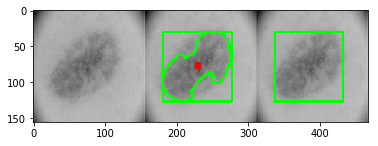

In [19]:
# Now for the new crops!
x, y, w, h = tuple(cv2.boundingRect(final_contours)) # starting x, starting y, box width, box height
# cv2.rectange(your_canvas, (1st corner x, 1st corner y), (2nd corner x, 2nd corner y), color, line width as before)
new_gray_color = convert(gray1) # My 5 AM, no-sleep self is not clever with variable names
cv2.rectangle(gray_color, (x, y), (x + w, y + h), GREEN, 2)
cv2.rectangle(new_gray_color, (x, y), (x + w, y + h), GREEN, 2)

grays = cv2.hconcat([convert(gray1), gray_color, new_gray_color])

plt.imshow(grays)

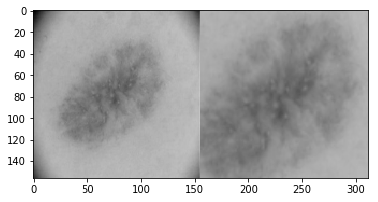

In [20]:
# Now to access the cropped image, ROI (region of interest)
ROI = cv2.resize(gray1[x: x + w, y: y + h], (IMG_SIZE, IMG_SIZE))

gray_finals = cv2.hconcat([gray1, ROI])
plt.imshow(gray_finals, cmap = "gray", vmin = 0, vmax = 255)

## Parting notes in no particular order
* Every data (image) set is different. Some methods here may not work for your images. Not only were these parameters fine-tuned for the images through trial and error, but many techniques were tried as well.
* Saliency detection is another algorithm used for detecting potential ROIs. With a bit of tinkering, saliency detection can be quite a condensed solution. <a href="https://www.pyimagesearch.com/2018/07/16/opencv-saliency-detection/">Check out Adrian Rosebrock's article for more details</a>.
* Resizing images multiple times can lead to undesired warpage. This can be avoided by insisting that the cropped region is square at the expense of a tighter crop.
* <code>cv2.imread('some_img')</code> converts the image to BGR (instead of RGB). To counteract this, try <code>cv2.cvtColor(some_cv2_img, cv2.COLOR_BGR2RGB)</code>

## Questions, comments, concerns?

* Most of the sources mentioned in this Notebook can be contacted on Twitter and are often generously willing to help
* If you're interested in more work from me, including the followup image classifier to this post, <a href="http://twitter.com/patrickjdarrow">follow me on Twitter for updates<a/>.
    
### Condensed code, displaying all steps of the process:

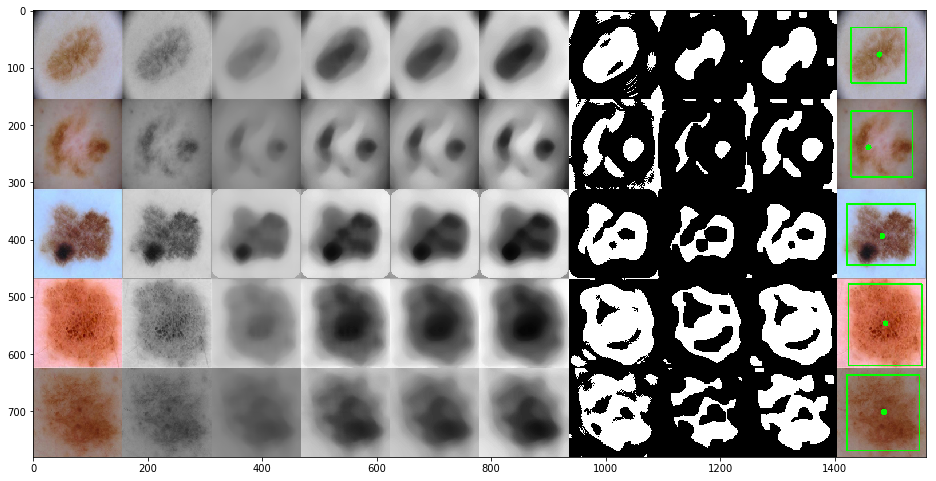

In [21]:
plt.rcParams['figure.figsize'] = (16,12)

for img in imgs:
    img = cv2.resize(cv2.imread(img), (IMG_SIZE, IMG_SIZE))
    final_img = img.copy()

    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (1, 1))# CLAHE (Contrast Limited Adaptive Histogram Equalization)
    
    blurred1 = cv2.medianBlur(gray.copy(), 21)
    cl1 = clahe.apply(blurred1)
    cl1_color = cv2.cvtColor(cl1.copy(), cv2.COLOR_GRAY2BGR)

    erosion_kernel = np.ones((5, 5), np.uint8)
    dilate_kernel = np.ones((5, 5), np.uint8)
    blurred2 = cv2.medianBlur(cl1.copy(), 15)
    cl2 = clahe.apply(blurred2)
    mask1 = cv2.adaptiveThreshold(cl2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 65, 1)
    eroded = cv2.erode(mask1, dilate_kernel, iterations = 2)
    dilated = cv2.dilate(eroded, dilate_kernel, iterations = 2)

    _, contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = contour_dist_to_center)
    central_contour = contours[0]
    final_contours = central_contour

    if len(contours) > 1:
        contour_threshold = contour_dist_to_center(central_contour) * 2
        final_contours = final_contours.tolist()
        for contour in contours:
            if contour_dist_to_center(contour) < contour_threshold:
                final_contours += contour.tolist()
        final_contours = np.array(final_contours)

    drawn_contour = cv2.drawContours(cl1_color, contours, 0, GREEN, -1)

    M = cv2.moments(final_contours)
    cX = int(M["m10"] / max(M["m00"], 1))
    cY = int(M["m01"] / max(M["m00"], 1))

    x, y, w, h = tuple(cv2.boundingRect(final_contours))
    cv2.rectangle(cl1_color, (x, y),(x + w, y + h), GREEN, 2)
    cv2.circle(cl1_color, (cX, cY), 5, GREEN, -1)
    cv2.rectangle(final_img, (x, y), (x + w, y + h), GREEN, 2)
    cv2.circle(final_img, (cX, cY), 5, GREEN, -1)

    concat = cv2.hconcat([cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                        convert(gray),
                        convert(blurred1),
                        convert(cl1), 
                        convert(blurred2),
                        convert(cl2),
                        convert(mask1),
                        convert(eroded),
                        convert(dilated),
                        cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)])
    concat_imgs.append(concat)
final_imgs = cv2.vconcat(concat_imgs)
plt.imshow(final_imgs)